<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Packages" data-toc-modified-id="Packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Play" data-toc-modified-id="Play-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Play</a></span></li></ul></div>

# Setup

In [1]:
cd("../..")

# Packages

In [2]:
include("./src/utils.jl")
using .Utils

In [3]:
using Statistics, Distributions, DataFrames, GLM, Query

In [4]:
using RCall
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 400));
R"""
library(GGally)
library(magrittr)
"""

┌ Warning: RCall.jl: Loading required package: ggplot2
│ Registered S3 method overwritten by 'GGally':
│   method from   
│   +.gg   ggplot2
└ @ RCall /home/user/.julia/packages/RCall/paaBQ/src/io.jl:113


RObject{StrSxp}
 [1] "magrittr"  "GGally"    "ggplot2"   "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     


# Common

In [5]:
const n = 1_000;

In [6]:
RMSE(y, ŷ) = (y .- ŷ).^2 |> mean |> sqrt;

function eval_model(model, df)
    rmse = RMSE(df.Y, predict(model, df))
    rsquared = r2(model)
    println("RMSE:\t$(round(rmse, digits = 4))")
    println("R^2:\t$(round(rsquared, digits = 4))")
end
;

# The Fork

$Z$ causes $X$ and $Y$:

In [7]:
z = rand(Normal(), n);
x = 2 .* z .+ rand(Normal(), n)
y = 3 .* z .+ rand(Normal(), n)

df = DataFrame(X = x, Z = z, Y = y)
first(df, 5)

,X,Z,Y
,Float64,Float64,Float64
1,-4.08369,-1.88972,-8.4049
2,-0.767182,-0.419245,-2.87607
3,-0.322579,0.323292,2.89562
4,0.495611,0.787839,2.07873
5,0.145101,0.65861,2.0293


Ground truth is $$Y = 3Z$$.

Model relationship between X and Y directly:

In [8]:
model = lm(@formula(Y ~ X + 0), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 0 + X

Coefficients:
────────────────────────────────────────────────────────────────
   Estimate  Std. Error  t value  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────
X   1.18115   0.0234364  50.3983    <1e-99    1.13516    1.22714
────────────────────────────────────────────────────────────────

In [9]:
R"""
lm(Y ~ X - 1, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Y ~ X - 1, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.6921 -1.1204  0.0639  1.1741  4.9146 

Coefficients:
  Estimate Std. Error t value Pr(>|t|)    
X  1.18115    0.02344    50.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.676 on 999 degrees of freedom
Multiple R-squared:  0.7177,	Adjusted R-squared:  0.7174 
F-statistic:  2540 on 1 and 999 DF,  p-value: < 2.2e-16



In [10]:
eval_model(model, df)

RMSE:	1.6752
R^2:	0.7172


Taking into account $Z$:

In [11]:
model = lm(@formula(Y ~ X + Z + 0), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 0 + X + Z

Coefficients:
──────────────────────────────────────────────────────────────────────
      Estimate  Std. Error    t value  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────
X  -0.00787921   0.030238   -0.260573    0.7945  -0.0672166  0.0514582
Z   2.99004      0.0678379  44.0762      <1e-99   2.85692    3.12316
──────────────────────────────────────────────────────────────────────

In [12]:
R"""
lm(Y ~ X + Z - 1, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Y ~ X + Z - 1, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1460 -0.6110  0.0419  0.6443  3.8228 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)    
X -0.007879   0.030238  -0.261    0.794    
Z  2.990038   0.067838  44.076   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9769 on 998 degrees of freedom
Multiple R-squared:  0.9042,	Adjusted R-squared:  0.904 
F-statistic:  4710 on 2 and 998 DF,  p-value: < 2.2e-16



In [13]:
eval_model(model, df)

RMSE:	0.9759
R^2:	0.904


Just $Z$:

In [14]:
model = lm(@formula(Y ~ Z + 0), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 0 + Z

Coefficients:
────────────────────────────────────────────────────────────────
   Estimate  Std. Error  t value  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────
Z   2.97427   0.0306312  97.0994    <1e-99    2.91416    3.03438
────────────────────────────────────────────────────────────────

In [15]:
R"""
lm(Y ~ Z - 1, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Y ~ Z - 1, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1537 -0.6063  0.0526  0.6465  3.8248 

Coefficients:
  Estimate Std. Error t value Pr(>|t|)    
Z  2.97427    0.03063    97.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9764 on 999 degrees of freedom
Multiple R-squared:  0.9042,	Adjusted R-squared:  0.9041 
F-statistic:  9428 on 1 and 999 DF,  p-value: < 2.2e-16



In [16]:
eval_model(model, df)

RMSE:	0.9759
R^2:	0.904


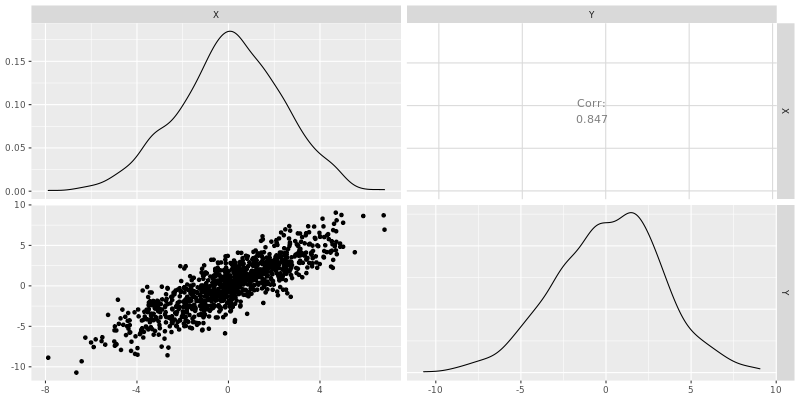

RObject{VecSxp}


In [17]:
R"""
ggpairs($df, columns = c("X", "Y"))
"""

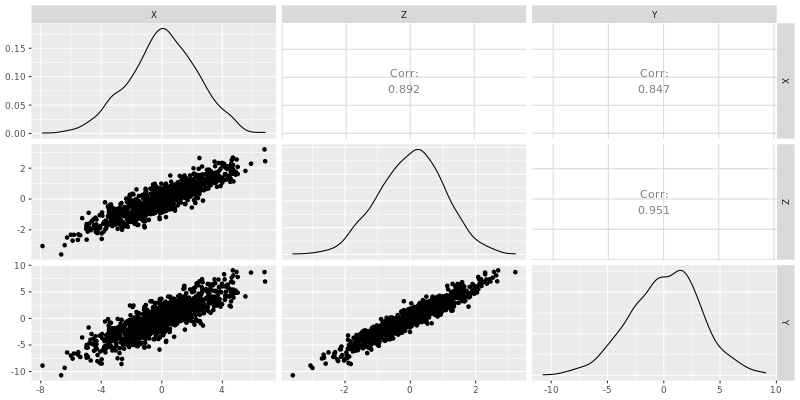

RObject{VecSxp}


In [18]:
R"""
ggpairs($df)
"""

# The Pipe

$X$ causes $Z$ which then causes $Y$.

In [19]:
x = vcat(zeros(Bool, n ÷ 2),  ones(Bool, n ÷ 2))
z = Bernoulli.(0.90 .- (x .* 0.8)) .|>
    d -> rand(d)
y = 10 .- 5 .* z + rand(Normal(), n)

df = DataFrame(X = x, Z = z, Y = y)
categorical!(df, [:X, :Z])

first(df, 5)

,X,Z,Y
,Categorical…,Categorical…,Float64
1,false,true,5.56111
2,false,true,4.61888
3,false,true,6.12642
4,false,true,5.64399
5,false,true,4.2466


Ground truth is $$ Y = 5.5 + 4.0 X$$

of $$ Y = 10 - 5 Z $$.

Because:

In [20]:
@from i in df begin
    @group i by i.X into k
    @select {X = key(k), Ȳ = mean(k.Y)}
    @collect DataFrame
end

,X,Ȳ
,Categorical…,Float64
1,false,5.55629
2,true,9.50906


Visualize:

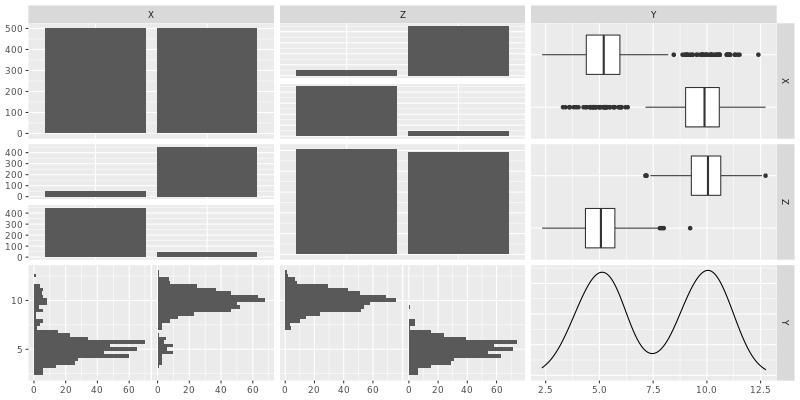

RObject{VecSxp}


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user/.julia/packages/RCall/paaBQ/src/io.jl:113


In [21]:
R"""
ggpairs($df)
"""

Model $Y$ as a function of both $X$ and $Z$:

In [22]:
model = lm(@formula(Y ~ X + Z), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X + Z

Coefficients:
───────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error     t value  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)  10.0345       0.106566   94.162       <1e-99   9.82534   10.2436
X: true      -0.0666048    0.107558   -0.619245    0.5359  -0.277671   0.144461
Z: true      -4.98683      0.107564  -46.3617      <1e-99  -5.1979    -4.77575
───────────────────────────────────────────────────────────────────────────────

In [23]:
R"""
lm(Y ~ X + Z, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Y ~ X + Z, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8778 -0.6924  0.0446  0.6781  4.1741 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  10.0345     0.1066  94.162   <2e-16 ***
Xtrue        -0.0666     0.1076  -0.619    0.536    
Ztrue        -4.9868     0.1076 -46.362   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.007 on 997 degrees of freedom
Multiple R-squared:  0.8576,	Adjusted R-squared:  0.8573 
F-statistic:  3002 on 2 and 997 DF,  p-value: < 2.2e-16



In [24]:
eval_model(model, df)

RMSE:	1.005
R^2:	0.8576


Model $Y$ as a function of $Z$:

In [25]:
model = lm(@formula(Y ~ Z), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + Z

Coefficients:
───────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)   9.97458   0.0447768  222.762     <1e-99    9.88671   10.0624
Z: true      -4.93314   0.0636429  -77.5127    <1e-99   -5.05803   -4.80825
───────────────────────────────────────────────────────────────────────────

In [26]:
R"""
lm(Y ~ Z, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Y ~ Z, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8311 -0.6920  0.0438  0.6777  4.1803 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.97458    0.04478  222.76   <2e-16 ***
Ztrue       -4.93314    0.06364  -77.51   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.006 on 998 degrees of freedom
Multiple R-squared:  0.8576,	Adjusted R-squared:  0.8574 
F-statistic:  6008 on 1 and 998 DF,  p-value: < 2.2e-16



In [27]:
eval_model(model, df)

RMSE:	1.0052
R^2:	0.8576


Model $Y$ as a function of $X$:

In [28]:
model = lm(@formula(Y ~ X), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error  t value  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   5.55629   0.0799263  69.5176    <1e-99    5.39944    5.71313
X: true       3.95278   0.113033   34.9701    <1e-99    3.73097    4.17459
──────────────────────────────────────────────────────────────────────────

In [29]:
R"""
lm(Y ~ X, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Y ~ X, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.2032 -0.8686  0.0150  0.8497  6.8410 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.55629    0.07993   69.52   <2e-16 ***
Xtrue        3.95278    0.11303   34.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.787 on 998 degrees of freedom
Multiple R-squared:  0.5506,	Adjusted R-squared:  0.5502 
F-statistic:  1223 on 1 and 998 DF,  p-value: < 2.2e-16



In [30]:
eval_model(model, df)

RMSE:	1.7854
R^2:	0.5506


# The Collider

$X$ causes $Z$, $Y$ causes $Z$:

In [31]:
x = rand(Normal(5, 1), n)
y = rand(Uniform(10, 20), n)

z = 2 * x + y + rand(Normal(), n)

df = DataFrame(X = x, Z = z, Y = y)

first(df, 5)

,X,Z,Y
,Float64,Float64,Float64
1,2.95804,15.6121,11.8255
2,4.15506,18.7824,12.0562
3,5.62719,23.2785,11.9277
4,4.64686,25.6021,16.6429
5,4.82417,26.6693,18.5938


Ground truth is $$Z = 2 X + Y $$

Visualize:

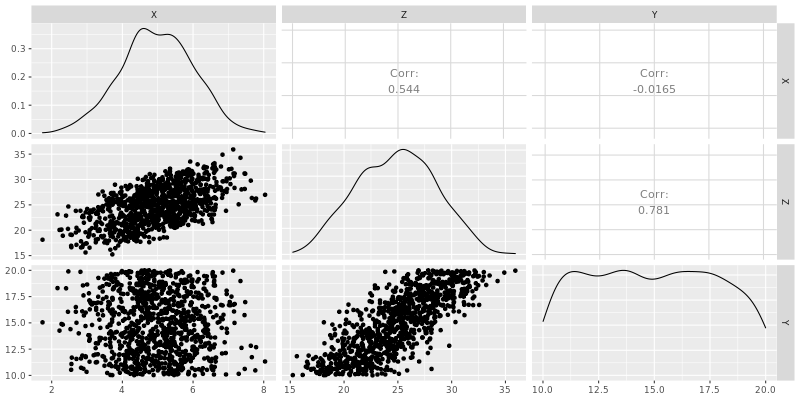

RObject{VecSxp}


In [32]:
R"""
ggpairs($df)
"""

Predict $Y$ as a function $X$ and $Z$:

In [33]:
model = lm(@formula(Y ~ X + Z), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X + Z

Coefficients:
─────────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error    t value  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   1.75063   0.213823      8.18727    <1e-15   1.33103    2.17022
X            -1.76118   0.0355712   -49.5115     <1e-99  -1.83098   -1.69138
Z             0.881365  0.00994319   88.6401     <1e-99   0.861853   0.900877
─────────────────────────────────────────────────────────────────────────────

In [34]:
R"""
lm(Y ~ X + Z, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Y ~ X + Z, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7575 -0.6073  0.0187  0.6492  2.6555 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.750628   0.213823   8.187 8.12e-16 ***
X           -1.761181   0.035571 -49.511  < 2e-16 ***
Z            0.881365   0.009943  88.640  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9677 on 997 degrees of freedom
Multiple R-squared:  0.8874,	Adjusted R-squared:  0.8872 
F-statistic:  3930 on 2 and 997 DF,  p-value: < 2.2e-16



In [35]:
eval_model(model, df)

RMSE:	0.9663
R^2:	0.8874


Predict $Y$ as a function fo $X$ only:

In [36]:
model = lm(@formula(Y ~ X), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error    t value  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  15.1233      0.45133    33.5083      <1e-99  14.2376    16.0089
X            -0.0462403   0.0889085  -0.520089    0.6031  -0.220709   0.128229
──────────────────────────────────────────────────────────────────────────────

In [37]:
R"""
lm(Y ~ X, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Y ~ X, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.9250 -2.5000 -0.0075  2.4479  5.1793 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 15.12328    0.45133   33.51   <2e-16 ***
X           -0.04624    0.08891   -0.52    0.603    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.882 on 998 degrees of freedom
Multiple R-squared:  0.000271,	Adjusted R-squared:  -0.0007308 
F-statistic: 0.2705 on 1 and 998 DF,  p-value: 0.6031



In [38]:
eval_model(model, df)

RMSE:	2.8795
R^2:	0.0003


Predict $Z$ as a function of $X$:

In [39]:
model = lm(@formula(Z ~ X), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Z ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error  t value  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  15.1726    0.482388   31.4532    <1e-99    14.226    16.1193
X             1.94578   0.0950268  20.4761    <1e-77     1.7593    2.13225
──────────────────────────────────────────────────────────────────────────

In [40]:
R"""
lm(Z ~ X, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Z ~ X, data = `#JL`$df)

Residuals:
   Min     1Q Median     3Q    Max 
-7.168 -2.455 -0.066  2.620  6.861 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 15.17265    0.48239   31.45   <2e-16 ***
X            1.94578    0.09503   20.48   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.081 on 998 degrees of freedom
Multiple R-squared:  0.2958,	Adjusted R-squared:  0.2951 
F-statistic: 419.3 on 1 and 998 DF,  p-value: < 2.2e-16



In [41]:
eval_model(model, df)

RMSE:	10.5607
R^2:	0.2958


Predict $Z$ as a function of $Y$:

In [42]:
model = lm(@formula(Z ~ Y), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Z ~ 1 + Y

Coefficients:
───────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error  t value  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  10.0251     0.381577   26.2729    <1e-99   9.27634    10.7739
Y             0.995168   0.0251546  39.562     <1e-99   0.945806    1.04453
───────────────────────────────────────────────────────────────────────────

In [43]:
R"""
lm(Z ~ Y, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Z ~ Y, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.8787 -1.5521  0.0318  1.5635  7.5436 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.02513    0.38158   26.27   <2e-16 ***
Y            0.99517    0.02515   39.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.291 on 998 degrees of freedom
Multiple R-squared:  0.6106,	Adjusted R-squared:  0.6102 
F-statistic:  1565 on 1 and 998 DF,  p-value: < 2.2e-16



In [44]:
eval_model(model, df)

RMSE:	9.9532
R^2:	0.6106


Predict $Z$ as function of $X$ and $Y$:

In [45]:
model = lm(@formula(Z ~ X + Y), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Z ~ 1 + X + Y

Coefficients:
──────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error    t value  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.0541111   0.236089   -0.229198    0.8188  -0.517399   0.409177
X             1.99233     0.0319079  62.4401      <1e-99   1.92972    2.05495
Y             1.00684     0.0113588  88.6401      <1e-99   0.984553   1.02913
──────────────────────────────────────────────────────────────────────────────

In [46]:
R"""
lm(Z ~ X + Y, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Z ~ X + Y, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0741 -0.6927  0.0055  0.6721  3.7903 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.05411    0.23609  -0.229    0.819    
X            1.99233    0.03191  62.440   <2e-16 ***
Y            1.00684    0.01136  88.640   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.034 on 997 degrees of freedom
Multiple R-squared:  0.9207,	Adjusted R-squared:  0.9205 
F-statistic:  5788 on 2 and 997 DF,  p-value: < 2.2e-16



In [47]:
eval_model(model, df)

RMSE:	10.1605
R^2:	0.9207


# Waffles

Data:

In [48]:
df = @from i in get_data("WaffleDivorce") begin
     @select {i.South, i.MedianAgeMarriage, i.Marriage, i.WaffleHouses, i.Divorce}
     @collect DataFrame
end

categorical!(df, :South)
first(df, 5)

,South,MedianAgeMarriage,Marriage,WaffleHouses,Divorce
,Categorical…,Float64,Float64,Int64,Float64
1,1,25.3,20.2,128,12.7
2,0,25.2,26.0,0,12.5
3,0,25.8,20.3,18,10.8
4,1,24.3,26.4,41,13.5
5,0,26.8,19.1,0,8.0


Visualize:

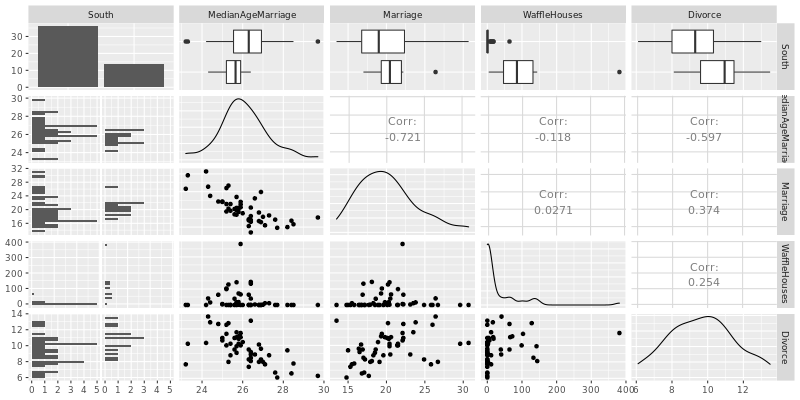

RObject{VecSxp}


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user/.julia/packages/RCall/paaBQ/src/io.jl:113


In [49]:
R"""
ggpairs($df)
"""

What are the factors that influence `Divorce`?

In [50]:
R"""
lm(Divorce ~ ., $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Divorce ~ ., data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0816 -0.9450  0.0297  0.8308  3.6046 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       33.470915   7.886981   4.244 0.000108 ***
South1             0.560303   0.656888   0.853 0.398196    
MedianAgeMarriage -0.892431   0.253175  -3.525 0.000986 ***
Marriage          -0.038176   0.080427  -0.475 0.637323    
WaffleHouses       0.002457   0.004387   0.560 0.578205    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.466 on 45 degrees of freedom
Multiple R-squared:  0.405,	Adjusted R-squared:  0.3522 
F-statistic: 7.659 on 4 and 45 DF,  p-value: 8.526e-05



Do Waffle Houses cause Divorce?

In [51]:
R"""
lm(Divorce ~ WaffleHouses, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Divorce ~ WaffleHouses, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3602 -1.3852 -0.1962  1.1239  3.7510 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.460231   0.280917  33.676   <2e-16 ***
WaffleHouses 0.007043   0.003863   1.823   0.0745 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.779 on 48 degrees of freedom
Multiple R-squared:  0.06476,	Adjusted R-squared:  0.04527 
F-statistic: 3.324 on 1 and 48 DF,  p-value: 0.07452



In [52]:
R"""
lm(Divorce ~ WaffleHouses + South, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Divorce ~ WaffleHouses + South, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1959 -1.2959  0.1246  0.9791  3.7041 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.2958758  0.2916480  31.874   <2e-16 ***
WaffleHouses 0.0009222  0.0052066   0.177   0.8602    
South1       1.2939325  0.7552357   1.713   0.0933 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.744 on 47 degrees of freedom
Multiple R-squared:  0.1197,	Adjusted R-squared:  0.08228 
F-statistic: 3.196 on 2 and 47 DF,  p-value: 0.04994



In [53]:
R"""
lm(Divorce ~ WaffleHouses + MedianAgeMarriage + Marriage, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Divorce ~ WaffleHouses + MedianAgeMarriage + Marriage, 
    data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2603 -0.8557  0.0613  0.9419  3.4942 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       35.085960   7.633619   4.596 3.36e-05 ***
WaffleHouses       0.005002   0.003207   1.560  0.12562    
MedianAgeMarriage -0.945234   0.244762  -3.862  0.00035 ***
Marriage          -0.046366   0.079615  -0.582  0.56315    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.461 on 46 degrees of freedom
Multiple R-squared:  0.3954,	Adjusted R-squared:  0.356 
F-statistic: 10.03 on 3 and 46 DF,  p-value: 3.352e-05



In [54]:
R"""
lm(Divorce ~ WaffleHouses + South + Marriage, $df) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Divorce ~ WaffleHouses + South + Marriage, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6213 -0.9508  0.0687  0.9325  4.7822 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.956721   1.263077   4.716 2.26e-05 ***
WaffleHouses 0.001452   0.004892   0.297  0.76792    
South1       1.126476   0.711667   1.583  0.12030    
Marriage     0.167491   0.061849   2.708  0.00947 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.637 on 46 degrees of freedom
Multiple R-squared:  0.2408,	Adjusted R-squared:  0.1913 
F-statistic: 4.863 on 3 and 46 DF,  p-value: 0.00508



Automatically find best model:

In [55]:
R"""
library(MASS)
m <- lm(Divorce ~ ., $df)
stepAIC(m, direction = "both", trace = FALSE) %>%
    summary
"""

RObject{VecSxp}

Call:
lm(formula = Divorce ~ South + MedianAgeMarriage, data = `#JL`$df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0300 -0.9713  0.1251  1.0379  3.8242 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        30.2477     4.4952   6.729 2.11e-08 ***
South1              0.8428     0.4690   1.797   0.0787 .  
MedianAgeMarriage  -0.7982     0.1710  -4.667 2.57e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.442 on 47 degrees of freedom
Multiple R-squared:  0.3981,	Adjusted R-squared:  0.3724 
F-statistic: 15.54 on 2 and 47 DF,  p-value: 6.599e-06

